This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [1]:
import argparse
import pathlib

import cellpose
import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch
from cellpose import core
from cellpose import io as cellpose_io
from cellpose import models

cellpose_io.logger_setup()
# set the gpu via OS environment variable
import os

from csbdeep.utils import normalize
from PIL import Image
from stardist.plot import render_label

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)
# check if we have a GPU
use_gpu = torch.cuda.is_available()
print("GPU activated:", use_gpu)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.3 
platform:       	linux 
python version: 	3.10.17 
torch version:  	2.7.0+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 


2025-05-16 12:13:24,596 [INFO] WRITING LOG OUTPUT TO /home/lippincm/.cellpose/run.log
2025-05-16 12:13:24,597 [INFO] 
cellpose version: 	4.0.3 
platform:       	linux 
python version: 	3.10.17 
torch version:  	2.7.0+cu126
True
GPU activated: True


In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )
    parser.add_argument(
        "--diameter",
        type=bool,
        help="diameter of the nuclei to segment",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)
    diameter = args.diameter

else:
    # input_dir = pathlib.Path(
    #     "../../2.cellprofiler_ic_processing/illum_directory/test_data/timelapse/20231017ChromaLive_6hr_4ch_MaxIP_C-03_F0001"
    # ).resolve(strict=True)
    input_dir = pathlib.Path(
        "../../2.cellprofiler_ic_processing/illum_directory/test_data/endpoint/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_E-11_F0001"
    ).resolve(strict=True)
    clip_limit = 0.6
    diameter = 70

In [3]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_before, total_before = torch.cuda.mem_get_info(device)
starting_level_GPU_RAM = (total_before - free_before) / 1024**2
print("Starting level of GPU RAM available (MB): ", starting_level_GPU_RAM)

Starting level of GPU RAM available (MB):  9231.75


## Set up images, paths and functions

In [4]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
print(len(files))

4


In [5]:
image_dict = {
    "nuclei_file_paths": [],
    "nuclei": [],
}

In [6]:
# split files by channel
for file in files:
    if "C01" in file.split("/")[-1]:
        image_dict["nuclei_file_paths"].append(file)
        image_dict["nuclei"].append(tifffile.imread(file).astype(np.float32))
nuclei_image_list = [np.array(nuclei) for nuclei in image_dict["nuclei"]]

nuclei = np.array(nuclei_image_list).astype(np.int16)

nuclei = skimage.exposure.equalize_adapthist(nuclei, clip_limit=clip_limit)

nuclei_image_list = [np.array(nuclei_image) for nuclei_image in nuclei]
print(len(nuclei_image_list))

1


## Cellpose

Weird errors occur when running this converted notebook in the command line.
This cell helps the python interpreter figure out where it is...somehow.

In [7]:
test = nuclei_image_list[0]
model_name = "nuclei"
diameter = 50

model = models.CellposeModel(model_type=model_name, gpu=True)

channels = [[1, 0]]

# # get masks
# for _ in range(1):
masks, flows, styles = model.eval(test, channels=channels, diameter=diameter)

2025-05-16 12:13:26,472 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-05-16 12:13:26,474 [INFO] ** TORCH CUDA version installed and working. **
2025-05-16 12:13:26,474 [INFO] >>>> using GPU (CUDA)
device: cuda:0
gpu: True
2025-05-16 12:13:28,217 [INFO] >>>> loading model /home/lippincm/.cellpose/models/cpsam
2025-05-16 12:13:29,041 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


In [8]:
# model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
model_name = "nuclei"
use_GPU = core.use_gpu()
print("GPU activated: ", use_GPU)
model = models.CellposeModel(model_type=model_name, gpu=use_GPU)

channels = [[1, 0]]

masks_all_dict = {"masks": [], "imgs": []}


def get_masks(image, model, channels, diameter):
    masks, flows, styles, _ = model.eval(
        normalize(image), channels=channels, diameter=diameter
    )
    return masks


# get masks for all the images
# save to a dict for later use
for img in range(nuclei.shape[0]):
    nuclei[img, :, :] = normalize(nuclei[img, :, :])

results = [
    (
        img,
        nuclei[img, :, :].shape,
        model.eval(nuclei[img, :, :], channels=channels, diameter=diameter),
    )
    for img in range(nuclei.shape[0])
]

# Print the results
for img, shape, (masks, flows, styles) in results:
    masks_all_dict["masks"].append(masks)
    masks_all_dict["imgs"].append(img)


masks_all = masks_all_dict["masks"]
imgs = masks_all_dict["imgs"]
masks_all = np.array(masks_all)
imgs = np.array(imgs)
print(masks_all.shape)
print(imgs.shape)

for frame_index, frame in enumerate(image_dict["nuclei_file_paths"]):
    tifffile.imwrite(
        pathlib.Path(
            input_dir / f"{str(frame).split('/')[-1].split('_C01')[0]}_nuclei_mask.tiff"
        ),
        masks_all[frame_index, :, :],
    )

2025-05-16 12:13:31,279 [INFO] ** TORCH CUDA version installed and working. **
GPU activated:  True
2025-05-16 12:13:31,279 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-05-16 12:13:31,280 [INFO] ** TORCH CUDA version installed and working. **
2025-05-16 12:13:31,280 [INFO] >>>> using GPU (CUDA)
device: cuda:0
gpu: True
2025-05-16 12:13:32,739 [INFO] >>>> loading model /home/lippincm/.cellpose/models/cpsam
2025-05-16 12:13:33,488 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
(1, 1900, 1900)
(1,)


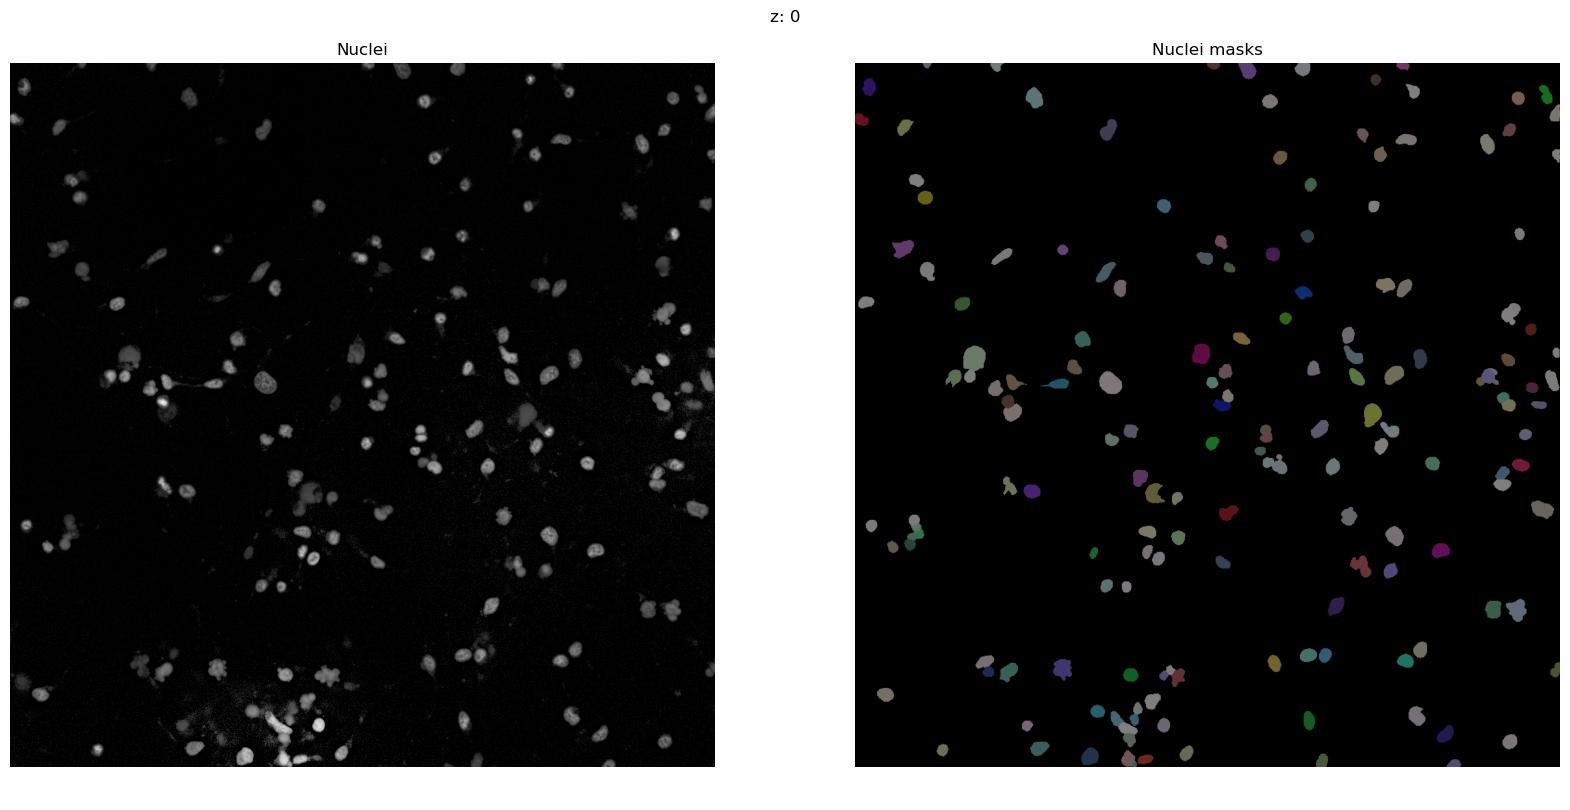

In [9]:
if in_notebook:
    for z in range(len(masks_all)):
        plt.figure(figsize=(20, 10))
        plt.title(f"z: {z}")
        plt.axis("off")
        plt.subplot(1, 2, 1)
        plt.imshow(nuclei[z], cmap="gray")
        plt.title("Nuclei")
        plt.axis("off")

        plt.subplot(122)
        plt.imshow(render_label(masks_all[z]))
        plt.title("Nuclei masks")
        plt.axis("off")
        plt.show()

In [10]:
# set up memory profiler for GPU
device = torch.device("cuda:0")
free_after, total_after = torch.cuda.mem_get_info(device)
amount_used = ((total_after - free_after)) / 1024**2
print(f"Used: {amount_used} MB or {amount_used / 1024} GB of GPU RAM")

Used: 13980.0 MB or 13.65234375 GB of GPU RAM
